In [68]:
import sys
sys.path.append('../tools')
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
from imageGenerator import ImageGenerator



NUM_CLASSES = 2
CLASSES = ['NEC', 'T1']
TRAIN_PATH = './dataset'   # dataset path
SIZE = 512  # original size (1920x912) -> (640x304)
BATCH_SIZE = 32  # size of the readed batches from generator, must fit on memory
VAL_SPLIT = 0.2  # fraction of the images used for validation


Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images is shape (32, 512, 512, 3)


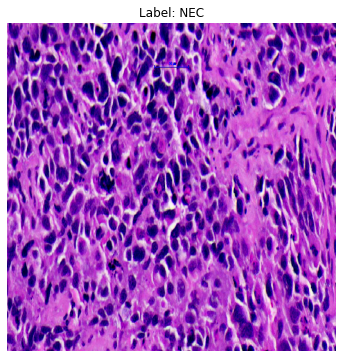

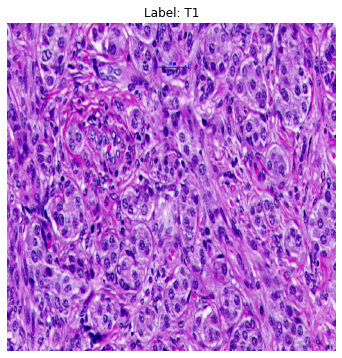

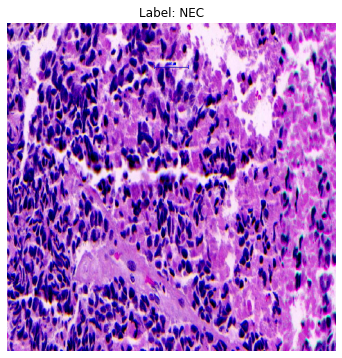

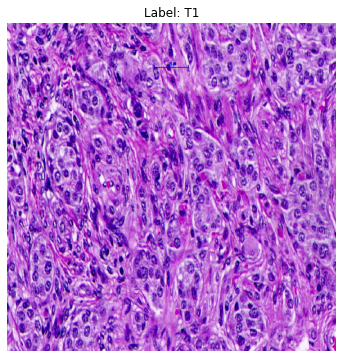

<function matplotlib.pyplot.show(close=None, block=None)>

In [69]:
##########           Image generators           ##########

def preprocess(images):
      return tf.keras.applications.mobilenet_v2.preprocess_input(images)
    

train_datagen = ImageDataGenerator(#rescale=1./255,
                                    #rotation_range = 5,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    #width_shift_range=0.0,
                                    #height_shift_range=0.0,
                                    fill_mode='wrap',
                                    #brightness_range=None,
                                    #horizontal_flip=True,
                                    #vertical_flip=True,
                                    validation_split=0.2,# set validation split
                                    preprocessing_function=preprocess
                                  )


train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    subset='training',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    target_size=(SIZE,SIZE)
                                                    )

validation_generator = train_datagen.flow_from_directory(TRAIN_PATH, # same directory as training data
                                                         subset='validation',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='binary',
                                                         shuffle=True,
                                                         target_size=(SIZE,SIZE)
                                                    )

images, labels = train_generator.__next__()
print('Images is shape', images.shape)
    
for i in range(4):
    f = plt.figure(figsize = (20, 20))
    f.add_subplot(1,3,1)
    plt.axis('off')
    plt. title('Label: '+str(CLASSES[int(labels[i])]))
    plt.imshow(images[i])
plt.show(block=True)
plt.show

In [39]:
##########          CNN Construction           ##########

IMG_SHAPE = (SIZE, SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(1, activation='sigmoid')
                        ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
##########           Training           ##########

history = model.fit(train_generator,
                    epochs=20,
                    #teps_per_epoch=train_steps,
                    validation_data=validation_generator,
                    #alidation_steps=val_steps,
                    #callbacks=callbacks
                   )

save_path = './trained_models/classification_model.hdf5'
print('Saving model to:', save_path)
model.save(save_path)

2022-07-19 10:50:50.465375: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-19 10:50:50.467384: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2700000000 Hz


Epoch 1/20


/mnt/beegfs/spack/opt/spack/linux-centos7-x86_64/gcc-4.9.4/miniconda3-4.3.30-rc2pkggawlbh6twcvefw6pwv7sgc6bc5/envs/tensorflow_2.5/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-07-19 10:50:54.591453: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-07-19 10:50:55.842692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2022-07-19 10:50:57.486257: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-19 10:50:58.562682: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


7/7 [==============================] - 24s 3s/step - loss: 0.7114 - accuracy: 0.5602 - val_loss: 0.6684 - val_accuracy: 0.6226
Epoch 2/20
7/7 [==============================] - 16s 2s/step - loss: 0.6986 - accuracy: 0.6065 - val_loss: 0.6120 - val_accuracy: 0.6604
Epoch 3/20
7/7 [==============================] - 16s 2s/step - loss: 0.6241 - accuracy: 0.6574 - val_loss: 0.5795 - val_accuracy: 0.6792
Epoch 4/20
7/7 [==============================] - 16s 2s/step - loss: 0.5972 - accuracy: 0.6667 - val_loss: 0.5840 - val_accuracy: 0.6792
Epoch 5/20
7/7 [==============================] - 16s 2s/step - loss: 0.5799 - accuracy: 0.6991 - val_loss: 0.5593 - val_accuracy: 0.6981
Epoch 6/20
7/7 [==============================] - 16s 2s/step - loss: 0.5202 - accuracy: 0.7685 - val_loss: 0.5065 - val_accuracy: 0.7547
Epoch 7/20
7/7 [==============================] - 16s 2s/step - loss: 0.5199 - accuracy: 0.7639 - val_loss: 0.4726 - val_accuracy: 0.7736
Epoch 8/20
7/7 [=============================

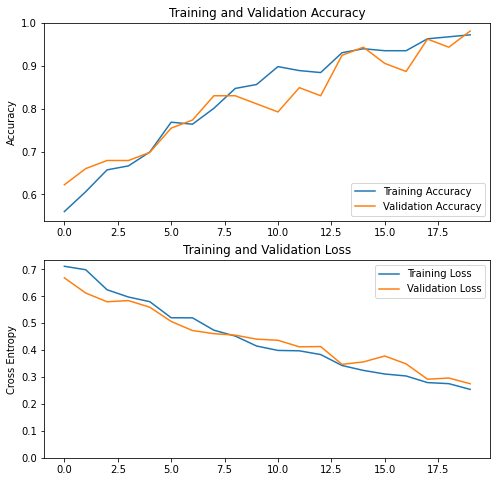

Maximum validation accuracy reached:  0.9811320900917053
Maximum validation accuracy reached at epoch:  20


In [56]:
##########           Model evaluation           ##########

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

max_iou = max(val_acc)
print ("Maximum validation accuracy reached: ", max_iou)
max_index = val_acc.index(max_iou)
print("Maximum validation accuracy reached at epoch: ",max_index+1)